In [16]:
import os
import numpy as np
import pandas as pd
import sklearn
import typing as tp
import re
import matplotlib.pyplot as plt

In [10]:
# https://webpages.uidaho.edu/ui-prmd/

base_data_dir: str = os.path.join('..', 'data', 'SemesterProject')

for parent_dir, folders, files in os.walk(base_data_dir):
    print('\n'.join(files))




m09_s04_positions.txt
m08_s02_positions.txt
m05_s01_positions.txt
m09_s01_positions.txt
m03_s02_positions.txt
m05_s06_positions.txt
m07_s03_positions.txt
m07_s08_positions.txt
m02_s09_positions.txt
m09_s09_positions.txt
m08_s10_positions.txt
m08_s08_positions.txt
m09_s05_positions.txt
m02_s01_positions.txt
m03_s01_positions.txt
m07_s01_positions.txt
m06_s02_positions.txt
m05_s03_positions.txt
m06_s10_positions.txt
m01_s01_positions.txt
m02_s03_positions.txt
m02_s06_positions.txt
m01_s06_positions.txt
m06_s03_positions.txt
m06_s06_positions.txt
m02_s10_positions.txt
m09_s03_positions.txt
m04_s03_positions.txt
m08_s05_positions.txt
m04_s08_positions.txt
m01_s09_positions.txt
m04_s07_positions.txt
m10_s04_positions.txt
m05_s08_positions.txt
m08_s03_positions.txt
m07_s05_positions.txt
m08_s07_positions.txt
m09_s07_positions.txt
m07_s07_positions.txt
m08_s04_positions.txt
m07_s02_positions.txt
m06_s01_positions.txt
m01_s07_positions.txt
m05_s05_positions.txt
m10_s03_positions.txt
m03_s03

## Constructing Training dataset

In [25]:
def rotate_z(t: np.ndarray) -> np.ndarray:
    # Rotation about Z axis
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[ct, -st, 0], [st, ct, 0], [0, 0, 1]])

def rotate_x(t: np.ndarray) -> np.ndarray:
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[1, 0, 0], [0, ct, -st], [0, st, ct]])

def rotate_y(t: np.ndarray) -> np.ndarray:
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[ct, 0, st], [0, 1, 0], [-st, 0, ct]])

def eulers_2_rot_matrix(x: np.ndarray) -> np.ndarray:
    # EULER_2_ROT_MATRIX transforms a set of euler angles into a rotation  matrix
    # This might need a couple of 0's attached to it.
    gamma_x: np.ndarray = x[0]
    beta_y: np.ndarray = x[1]
    alpha_z: np.ndarray = x[2]

    return rotate_z(alpha_z) * rotate_y(beta_y) * rotate_x(gamma_x)

def rotate_joint(curr_joint: np.ndarray, prev_joint_angle: np.ndarray, prev_joint_position: np.ndarray) -> np.ndarray:
    rotate_current_joint: np.ndarray = eulers_2_rot_matrix(prev_joint_angle)

    print(rotate_current_joint.shape)

    return (rotate_current_joint * curr_joint.T.reshape((1, -1))).T + prev_joint_position.reshape((1, -1))


In [28]:
# I think I'm gonna work with the Kinect since that one is one I can get a hold of if I need to.

# Going based on animation.m from the source.

kinect_pos_base_dir: str = os.path.join(base_data_dir, 'Movements', 'Kinect', 'Positions')
kinect_ang_base_dir: str = os.path.join(base_data_dir, 'Movements', 'Kinect', 'Angles')

parser_pattern: re.Pattern = re.compile(r'm(?P<movement>\d{2})_s(?P<subject>\d{2}).*s\.txt')

correct_movements: tp.List[tp.Dict[str, tp.Union[np.ndarray, int]]] = []

for fp in os.listdir(kinect_pos_base_dir):
    parsed_match: re.Match = parser_pattern.match(fp)
    movement_id: int = int(parsed_match['movement'])
    subject_id: int = int(parsed_match['subject'])

    pos_path: str = os.path.join(kinect_pos_base_dir, f'm{movement_id:02}_s{subject_id:02}_positions.txt')
    ang_path: str = os.path.join(kinect_ang_base_dir, f'm{movement_id:02}_s{subject_id:02}_angles.txt')

    if not os.path.exists(pos_path) or not os.path.exists(ang_path):
        continue

    pos_array: np.ndarray = np.loadtxt(pos_path)
    ang_array: np.ndarray = np.loadtxt(ang_path)

    n_frames: int = pos_array.shape[0]

    skeleton_pos: np.ndarray = np.zeros((22, 3, n_frames))
    skeleton_ang: np.ndarray = np.zeros((22, 3, n_frames))
    pos_array1: np.ndarray = pos_array.T
    ang_array1: np.ndarray = ang_array.T

    for i in range(n_frames):
        skeleton_pos[:, :, i] = pos_array1[:, i].reshape((3, 22)).T
        skeleton_ang[:, :, i] = ang_array1[:, i].reshape((3, 22)).T



    """
    % 1 Waist (absolute)
% 2 Spine
% 3 Chest
% 4 Neck
% 5 Head
% 6 Head tip
% 7 Left collar
% 8 Left upper arm
% 9 Left forearm
% 10 Left hand
% 11 Right collar
% 12 Right upper arm
% 13 Right forearm
% 14 Right hand
% 15 Left upper leg
% 16 Left lower leg
% 17 Left foot
% 18 Left leg toes
% 19 Right upper leg
% 20 Right lower leg
% 21 Right foot
% 22 Right leg toes
    """

    joint_connections: np.ndarray = np.array([[4, 6, 5, 3, 2, 3, 7, 8, 9, 3, 11,  12, 13, 1,  15, 16, 17, 1,  19, 20, 21], [3, 5, 3, 2, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]])

    skeleton: np.ndarray = np.zeros((22, 3, n_frames))

    for i in range(n_frames):
        joint: np.ndarray = skeleton_pos[:, :, i]
        joint_angle: np.ndarray = np.deg2rad(skeleton_ang[:, :, i])

        for j in range(1, 23):
            print(f'Joint Shape: {joint[j].shape} / Prev Joint Angle Shape: {joint_angle[j - 1].shape} / Prev Joint Position Shape: {joint[j - 1, :].shape}')

            joint_rotation: np.ndarray = rotate_joint(joint[j, :], joint_angle[j - 1], joint[j - 1, :])

            print(f'Joint Rotation Shape: {joint_rotation.shape}')

            joint[j, np.newaxis] = joint_rotation

        skeleton[:, :, i] = joint

    correct_movements.append({'movement_id': movement_id, 'subject_id': subject_id, 'positions': pos_array, 'angles': ang_array, 'positions_path': pos_path, 'angles_path': ang_path, 'skeleton': skeleton})

pd.DataFrame.from_records(correct_movements)

Joint Shape: (3,) / Prev Joint Angle Shape: (3,) / Prev Joint Position Shape: (3,)
(3, 3)
Joint Rotation Shape: (3, 3)


ValueError: could not broadcast input array from shape (3,3) into shape (1,3)

In [15]:
pos_array

array([[ 9.7917000e+00,  8.6799800e+01, -2.4159789e+02, ...,
         0.0000000e+00, -1.0000000e-05,  1.1278200e+01],
       [ 9.8003100e+00,  8.6804050e+01, -2.4159789e+02, ...,
         0.0000000e+00, -1.0000000e-05,  1.1278200e+01],
       [ 9.8157300e+00,  8.6812320e+01, -2.4159789e+02, ...,
         0.0000000e+00, -1.0000000e-05,  1.1278200e+01],
       ...,
       [ 9.0432800e+00,  8.7738720e+01, -2.4234169e+02, ...,
         0.0000000e+00, -1.0000000e-05,  1.1164490e+01],
       [ 9.0303100e+00,  8.7694470e+01, -2.4231322e+02, ...,
         0.0000000e+00, -1.0000000e-05,  1.1164490e+01],
       [ 9.0168100e+00,  8.7628120e+01, -2.4227748e+02, ...,
         0.0000000e+00, -1.0000000e-05,  1.1164490e+01]])

In [18]:
pos_array.shape, ang_array.shape

((841, 66), (841, 66))

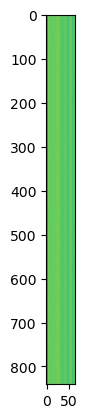

In [17]:
plt.imshow(pos_array)

In [13]:
ang_array

array([[ 0.26788, -1.22513, -2.17909, ...,  0.     ,  0.     ,  0.     ],
       [ 0.25347, -1.306  , -2.20294, ...,  0.     ,  0.     ,  0.     ],
       [ 0.31038, -1.24019, -2.20473, ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 0.46674, -2.15325, -2.21451, ...,  0.     ,  0.     ,  0.     ],
       [ 0.50716, -2.09538, -2.12364, ...,  0.     ,  0.     ,  0.     ],
       [ 0.50979, -2.16663, -1.88024, ...,  0.     ,  0.     ,  0.     ]])